In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import tqdm
import gc
import psutil
import random
import transformers
from sentence_transformers import SentenceTransformer
from torchmetrics import F1Score

In [2]:
gc.collect()

100

In [3]:
print(f"всего свободно памяти {psutil.virtual_memory().available/1024**3: .2f} gb\nкод занимает: {psutil.Process().memory_info().rss/1024**3: .2f}gb")

всего свободно памяти  16.98 gb
код занимает:  0.91gb


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.random.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [6]:
df = pd.read_csv("email_text.csv")
df = df.iloc[:1000, :]
df.shape

(1000, 2)

In [7]:
df.head(10)

,label,text
0,0,the mailing list i queried about a few weeks a...
1,1,luxury watches buy your own rolex for only esc...
2,1,academic qualifications available from prestig...
3,0,greetings all this is to verify your subscript...
4,1,try chauncey may conferred the luscious not co...
5,0,it's quiet too quiet well how about a straw po...
6,0,it's working here i have departed almost total...
7,1,from nbc today show it's the look everyone wan...
8,1,the oil sector is going crazy this is our week...
9,1,little magic perfect weekends http othxu escap...


In [8]:
df.isnull().sum() #нет пропусков

label    0
text     0
dtype: int64

In [9]:
stop_words = stopwords.words("english")
lem_words = WordNetLemmatizer()
len(stop_words)

198

In [10]:
def text_changing(data, stop_words):
    data = data.str.lower()
    short_dict = {"i'm":"i am", "'re": " are", "don't":"do not", "can't": "can not", "'d":" would","won't":"will not", "n't":" not", "'ve":" have", "'ll":" will"}
    for k, v in short_dict.items():
        data = data.str.replace(k,v)
    data = data.str.replace(r"[^a-zA-Z0-9\s]"," ", regex = True)
    data = data.str.replace(r"\s+", " ", regex = True)
    data = data.str.strip()
    for i in data.index.tolist():
        l_word_stop, l_word_lem = [],[]
        token = word_tokenize(data[i])
        for word in token:
            if word not in stop_words:
                l_word_stop.append(word)
        for word in l_word_stop:
            word_lem = lem_words.lemmatize(word)
            l_word_lem.append(word_lem)
        data[i] = " ".join(l_word_lem)

    return data
        
        
    
    

In [11]:
df["text_changed"] = text_changing(df["text"], stop_words)
df.head(10)

,label,text,text_changed
0,0,the mailing list i queried about a few weeks a...,mailing list queried week ago running also set...
1,1,luxury watches buy your own rolex for only esc...,luxury watch buy rolex escapenumber rolex cart...
2,1,academic qualifications available from prestig...,academic qualification available prestigious n...
3,0,greetings all this is to verify your subscript...,greeting verify subscription planescapenumber ...
4,1,try chauncey may conferred the luscious not co...,try chauncey may conferred luscious continued ...
5,0,it's quiet too quiet well how about a straw po...,quiet quiet straw po many planescapenumber run...
6,0,it's working here i have departed almost total...,working departed almost tota willy lab recomme...
7,1,from nbc today show it's the look everyone wan...,nbc today show look everyone want body diet be...
8,1,the oil sector is going crazy this is our week...,oil sector going crazy weekly gift get kkpt fi...
9,1,little magic perfect weekends http othxu escap...,little magic perfect weekend http othxu escape...


In [12]:
df["label"].value_counts(normalize = True)

label
0    0.652
1    0.348
Name: proportion, dtype: float64

In [13]:
model_bert = r"C:\Users\vasan\bert-based-uncased"


In [14]:
model = SentenceTransformer(model_bert, local_files_only=True)

No sentence-transformers model found with name C:\Users\vasan\bert-based-uncased. Creating a new one with mean pooling.


In [15]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [18]:
embeddings = model.encode(df["text_changed"])

In [19]:
embeddings.shape

(1000, 768)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(embeddings, df["label"], test_size=0.2, stratify=df["label"], random_state=seed, shuffle=True)

In [22]:
x_train.shape, x_test.shape

((800, 768), (200, 768))

In [21]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(label
 0    0.6525
 1    0.3475
 Name: proportion, dtype: float64,
 label
 0    0.65
 1    0.35
 Name: proportion, dtype: float64)

In [ ]:
x_train_tensor = torch.tensor(x_train.tolist(), dtype=torch.float)
x_test_tensor = torch.tensor(x_test.tolist(), dtype=torch.float)
y_train_tensor = torch.tensor(y_train.tolist(), dtype=torch.long)
y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.long)

In [23]:
train_data = TensorDataset(x_train_tensor, y_train_tensor)
test_data = TensorDataset(x_test_tensor, y_test_tensor)

In [24]:
train_loader = DataLoader(train_data, batch_size = 64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

In [25]:
class SpamDetector(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        #x = self.sigmoid(x)

        return x
        

In [26]:
def modeling(model, train_loader, test_loader, loss_f, optimizer,n_epochs):
    acc_train_list, acc_test_list, avg_loss_train_list, avg_loss_test_list, f1_score_list = [],[],[],[],[]
    f1_best, acc_best, best_epoch  = 0,0,0
    for epoch in range(n_epochs):
        model.train()
        score = F1Score(task="binary").to(device)
        correct, sum_loss =0,0
        for _,(data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_f(output, target)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()
            pred = output.argmax(dim = 1)
            correct += pred.eq(target.view_as(pred)).sum().item()
        acc_train =correct/len(train_loader.dataset)
        avg_loss_train = sum_loss/len(train_loader)
        acc_train_list.append(acc_train)
        avg_loss_train_list.append(avg_loss_train)

        print(f"для эпохи: {epoch+1} точность на трейне:{acc_train: .4f}, значение функции потерь на трейне : {avg_loss_train: .4f}")

        model.eval()
        correct_test, sum_loss_test = 0,0
        for _, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
                loss = loss_f(output, target)
                sum_loss_test += loss.item()
                pred = output.argmax(dim =1)
                correct_test += pred.eq(target.view_as(pred)).sum().item()
                score.update(pred, target)
        acc_test = correct_test/len(test_loader.dataset)
        avg_loss_test = sum_loss_test/len(test_loader)
        f1_score = score.compute()
        acc_test_list.append(acc_test)
        avg_loss_test_list.append(avg_loss_test)
        f1_score_list.append(f1_score)
        if f1_best < f1_score and abs(acc_test-acc_train)<0.01:
            f1_best = f1_score
            acc_best = acc_test
            best_epoch = epoch

        print(f"точность на тесте: {acc_test: .4f}, значение функции потерь на тесте: {avg_loss_test: .4f}, значение f1: {f1_score: .4f}")
    print(f" лучшее значение метрики f1: {f1_best: .4f} получено в {best_epoch+1} эпохе, точность составляет {acc_best: .4f}")

    return acc_train_list, acc_test_list, avg_loss_train_list, avg_loss_test_list, f1_score_list
                
                                     
            
    

In [28]:
model_bert = SpamDetector(input_size = embeddings.shape[1], hidden_size=128, output_size=2, dropout=0.5)
model_bert = model_bert.to(device)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_bert.parameters(), lr = 1e-3)
n_epochs = 30

In [29]:
acc_train_list, acc_test_list, avg_loss_train_list, avg_loss_test_list, f1_score_list = modeling(model_bert,train_loader, test_loader, loss_f, optimizer, n_epochs)

для эпохи: 1 точность на трейне: 0.6837, значение функции потерь на трейне :  0.5707
точность на тесте:  0.7600, значение функции потерь на тесте:  0.5009, значение f1:  0.6308
для эпохи: 2 точность на трейне: 0.8137, значение функции потерь на трейне :  0.4172
точность на тесте:  0.8600, значение функции потерь на тесте:  0.3940, значение f1:  0.7778
для эпохи: 3 точность на трейне: 0.8638, значение функции потерь на трейне :  0.3300
точность на тесте:  0.8950, значение функции потерь на тесте:  0.3165, значение f1:  0.8489
для эпохи: 4 точность на трейне: 0.8925, значение функции потерь на трейне :  0.2731
точность на тесте:  0.9150, значение функции потерь на тесте:  0.2549, значение f1:  0.8741
для эпохи: 5 точность на трейне: 0.9150, значение функции потерь на трейне :  0.2252
точность на тесте:  0.9500, значение функции потерь на тесте:  0.2187, значение f1:  0.9265
для эпохи: 6 точность на трейне: 0.9437, значение функции потерь на трейне :  0.1977
точность на тесте:  0.9450, зн

In [29]:
f1_score_cpu = []
for i in range(len(f1_score_list)):
    f1_score_cpu.append(f1_score_list[i].item())

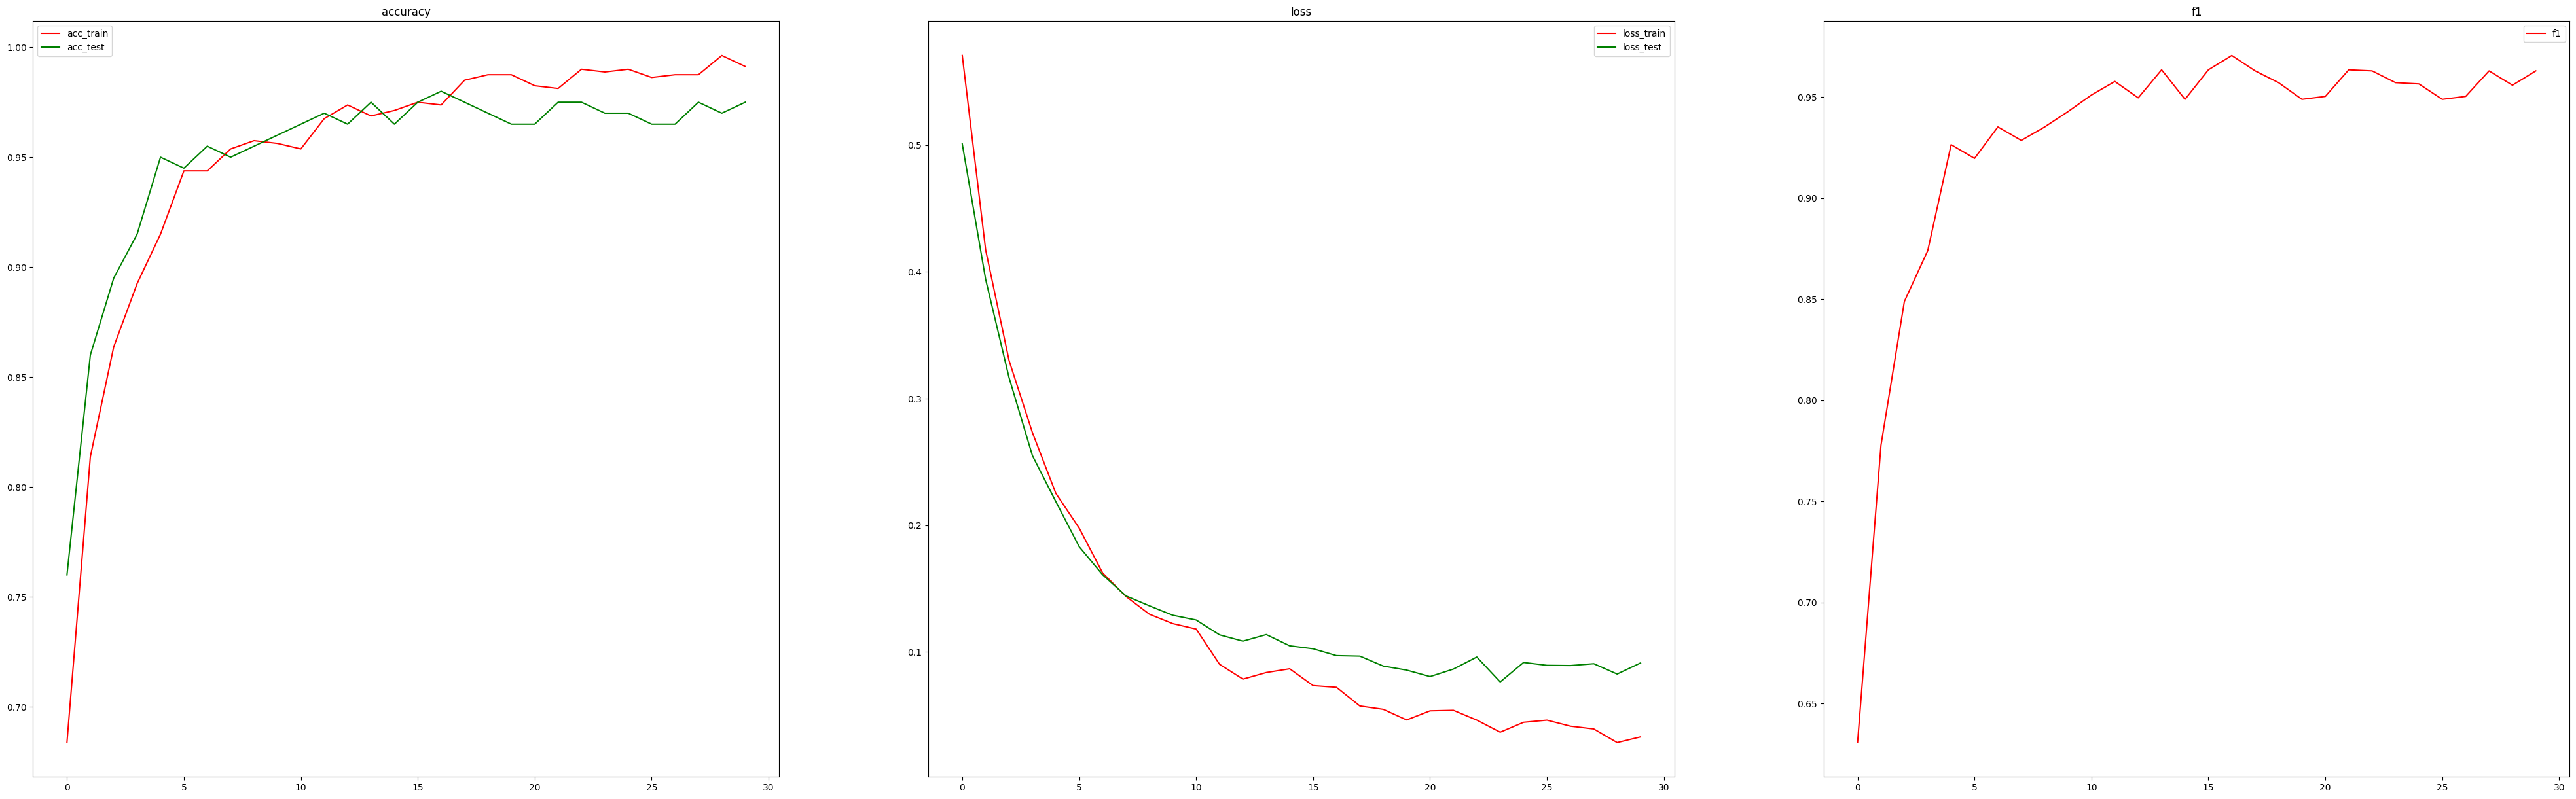

In [30]:
fig, axs = plt.subplots(1,3,figsize = (50,15))
axs[0].plot(range(n_epochs), acc_train_list, color = "red", label = "acc_train")
axs[0].plot(range(n_epochs), acc_test_list, color = "green", label = "acc_test")
axs[0].legend()
axs[0].set_title("accuracy")

axs[1].plot(range(n_epochs), avg_loss_train_list, color = "red", label = "loss_train")
axs[1].plot(range(n_epochs), avg_loss_test_list, color = "green", label = "loss_test")
axs[1].legend()
axs[1].set_title("loss")

axs[2].plot(range(n_epochs), f1_score_cpu, color = "red", label = "f1")
axs[2].legend()
axs[2].set_title("f1");

In [31]:
tokenizer_gpt = transformers.GPT2Tokenizer.from_pretrained("gpt2")
tokenizer_gpt.pad_token = tokenizer_gpt.eos_token
model_gpt = transformers.GPT2Model.from_pretrained("gpt2")


In [32]:
model_gpt = model_gpt.to(device)
batch_size = 25
def embedded(data, batch_size):
    all_embeddings = []
    iterations = 0
    for i in range(0, len(data), batch_size):
        start = i
        end = start+batch_size
        text = data[start:end]
        inputs = tokenizer_gpt(text.tolist(), padding = True, return_tensors = "pt", truncation = True).to(device)
        inputs = {key : value.to(device) for key, value in inputs.items()}
        with torch.no_grad():
            outputs = model_gpt(**inputs)
            embeddings_batch = outputs.last_hidden_state
            mask_batch = inputs["attention_mask"].unsqueeze(-1)
            nul_pad_mask = embeddings_batch*mask_batch
            sum_features = torch.sum(nul_pad_mask, dim = 1)
            sum_mask = torch.sum(mask_batch, dim = 1).clamp(min = 1e-9)
            embeddings = sum_features/sum_mask
            all_embeddings.append(embeddings.cpu())
            iterations +=1
        print(f" batch {iterations} из {len(data)/batch_size} завершен")            
    return torch.cat(all_embeddings, dim = 0)         
            
        

In [33]:
embeddings_gpt = embedded(df["text_changed"], batch_size)

 batch 1 из 40.0 завершен
 batch 2 из 40.0 завершен
 batch 3 из 40.0 завершен
 batch 4 из 40.0 завершен
 batch 5 из 40.0 завершен
 batch 6 из 40.0 завершен
 batch 7 из 40.0 завершен
 batch 8 из 40.0 завершен
 batch 9 из 40.0 завершен
 batch 10 из 40.0 завершен
 batch 11 из 40.0 завершен
 batch 12 из 40.0 завершен
 batch 13 из 40.0 завершен
 batch 14 из 40.0 завершен
 batch 15 из 40.0 завершен
 batch 16 из 40.0 завершен
 batch 17 из 40.0 завершен
 batch 18 из 40.0 завершен
 batch 19 из 40.0 завершен
 batch 20 из 40.0 завершен
 batch 21 из 40.0 завершен
 batch 22 из 40.0 завершен
 batch 23 из 40.0 завершен
 batch 24 из 40.0 завершен
 batch 25 из 40.0 завершен
 batch 26 из 40.0 завершен
 batch 27 из 40.0 завершен
 batch 28 из 40.0 завершен
 batch 29 из 40.0 завершен
 batch 30 из 40.0 завершен
 batch 31 из 40.0 завершен
 batch 32 из 40.0 завершен
 batch 33 из 40.0 завершен
 batch 34 из 40.0 завершен
 batch 35 из 40.0 завершен
 batch 36 из 40.0 завершен
 batch 37 из 40.0 завершен
 batch 38 

In [34]:
x_train_gpt, x_test_gpt, y_train_gpt, y_test_gpt = train_test_split(embeddings_gpt, df["label"], test_size = 0.2, stratify = df["label"], shuffle = True, random_state = seed)

In [58]:
y_train_tensor_gpt = torch.tensor(y_train_gpt.tolist(), dtype = torch.long)
y_test_tensor_gpt = torch.tensor(y_test_gpt.tolist(), dtype = torch.long)
train_data_gpt = TensorDataset(x_train_gpt, y_train_tensor_gpt)
test_data_gpt = TensorDataset(x_test_gpt, y_test_tensor_gpt)
train_loader_gpt = DataLoader(train_data_gpt, batch_size = batch_size, shuffle = True)
test_loader_gpt = DataLoader(test_data_gpt, batch_size = batch_size)

In [59]:
model_gpt = SpamDetector(input_size = embeddings_gpt.shape[1], hidden_size=32, output_size=2, dropout=0.2)
model_gpt = model_gpt.to(device)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_gpt.parameters(), lr = 1e-3)
n_epochs = 30

In [60]:
acc_train_list_gpt, acc_test_list_gpt, avg_loss_train_list_gpt, avg_loss_test_list_gpt, f1_score_list_gpt = modeling(model_gpt,train_loader_gpt, test_loader_gpt, loss_f, optimizer, n_epochs)

для эпохи: 1 точность на трейне: 0.6637, значение функции потерь на трейне :  0.6338
точность на тесте:  0.7400, значение функции потерь на тесте:  0.4931, значение f1:  0.4583
для эпохи: 2 точность на трейне: 0.8175, значение функции потерь на трейне :  0.4398
точность на тесте:  0.8800, значение функции потерь на тесте:  0.3684, значение f1:  0.8033
для эпохи: 3 точность на трейне: 0.8612, значение функции потерь на трейне :  0.3420
точность на тесте:  0.9000, значение функции потерь на тесте:  0.3029, значение f1:  0.8361
для эпохи: 4 точность на трейне: 0.9100, значение функции потерь на трейне :  0.2539
точность на тесте:  0.9050, значение функции потерь на тесте:  0.2370, значение f1:  0.8707
для эпохи: 5 точность на трейне: 0.9275, значение функции потерь на трейне :  0.2251
точность на тесте:  0.9150, значение функции потерь на тесте:  0.2002, значение f1:  0.8859
для эпохи: 6 точность на трейне: 0.9387, значение функции потерь на трейне :  0.1761
точность на тесте:  0.9600, зн

In [61]:
f1_gpt_cpu = []
for i in range(len(f1_score_list_gpt)):
    f1_gpt_cpu.append(f1_score_list_gpt[i].item())

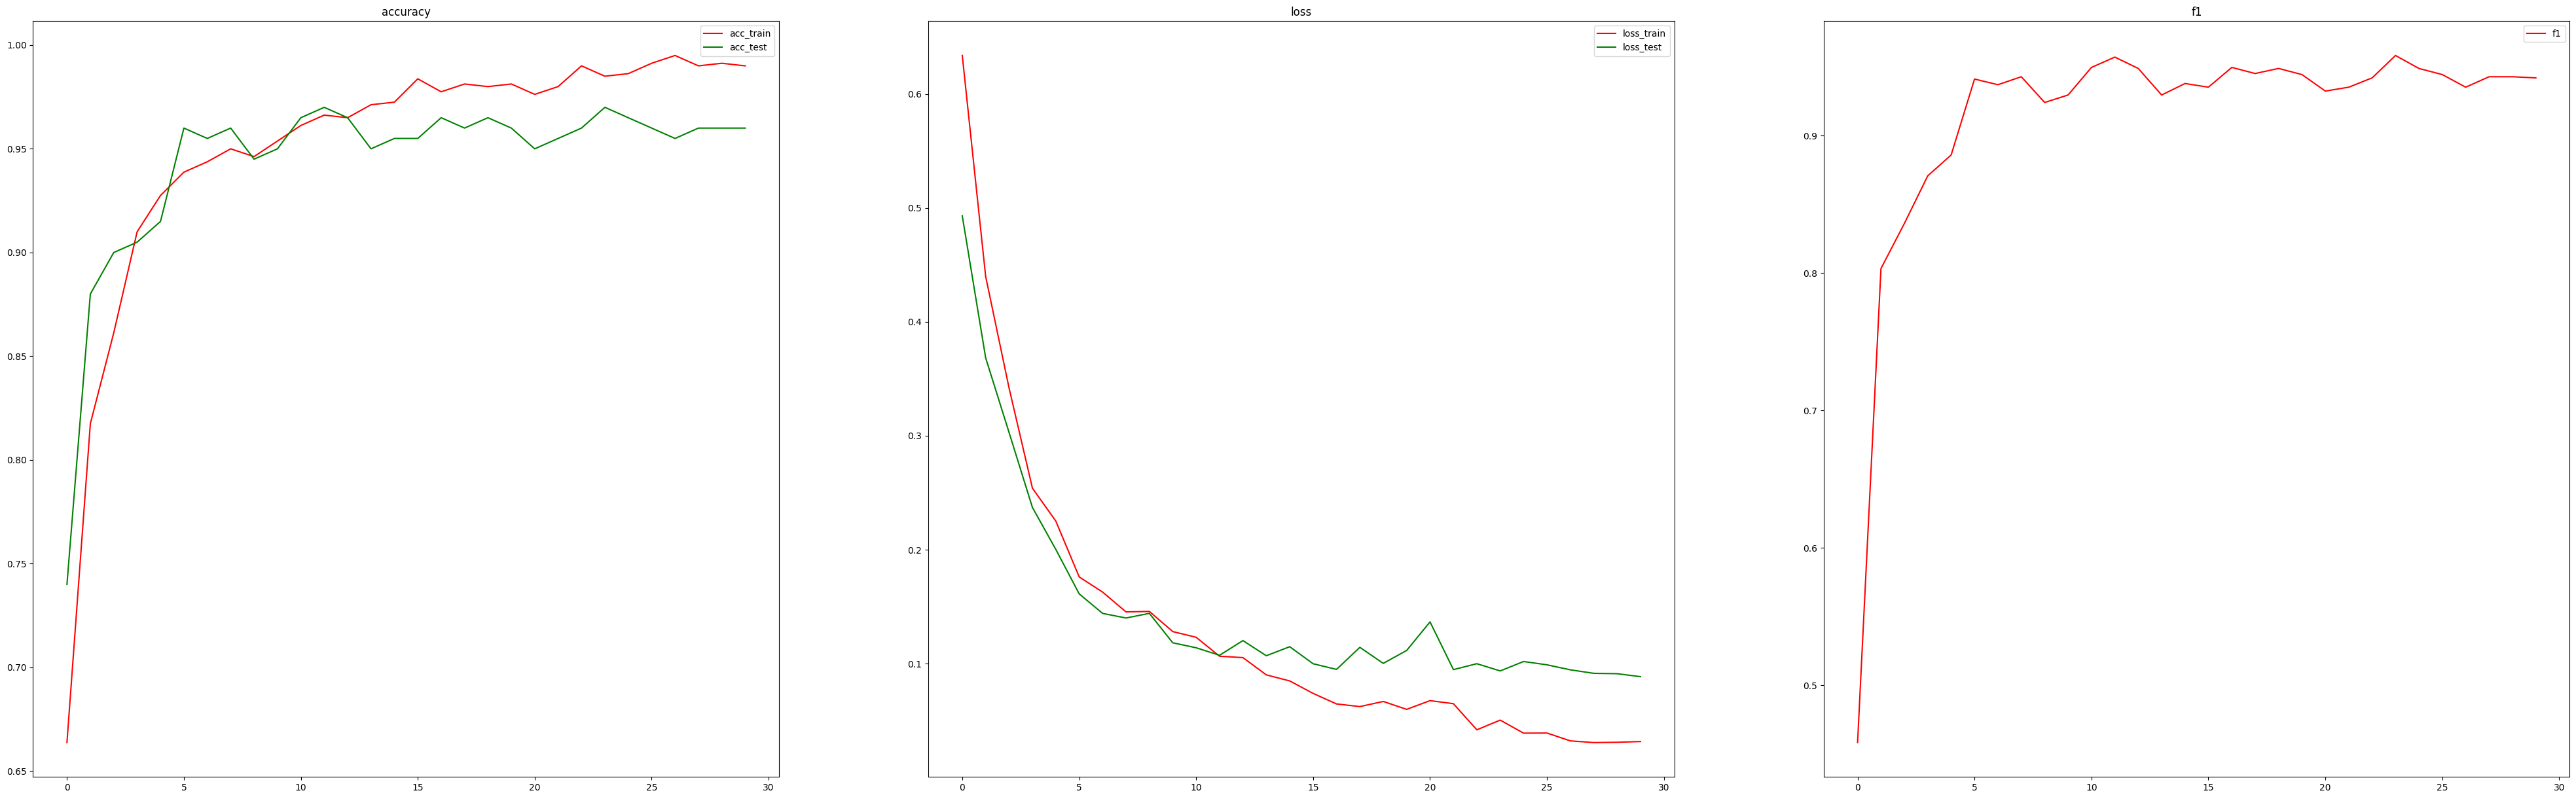

In [62]:
fig, axs = plt.subplots(1,3,figsize = (50,15))
axs[0].plot(range(n_epochs), acc_train_list_gpt, color = "red", label = "acc_train")
axs[0].plot(range(n_epochs), acc_test_list_gpt, color = "green", label = "acc_test")
axs[0].legend()
axs[0].set_title("accuracy")

axs[1].plot(range(n_epochs), avg_loss_train_list_gpt, color = "red", label = "loss_train")
axs[1].plot(range(n_epochs), avg_loss_test_list_gpt, color = "green", label = "loss_test")
axs[1].legend()
axs[1].set_title("loss")

axs[2].plot(range(n_epochs), f1_gpt_cpu, color = "red", label = "f1")
axs[2].legend()
axs[2].set_title("f1");